## Import Library

In [1]:
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 50
sns.set(style='darkgrid')
%matplotlib inline

## Load Data

In [2]:
# normal, fraud, promo
news = pd.read_csv('./Dataset/indosum datasets.txt', header=None, delimiter='\t')
news.columns = ['kategori','sumber','artikel']
news.head()

,kategori,sumber,artikel
0,teknologi,kumparan,Uber pada hari Jumat mengatakan akan menguak d...
1,teknologi,dailysocial.id,"Menyusul jejak NES Classic Edition , SNES Clas..."
2,teknologi,dailysocial.id,"MDI Ventures , perusahaan modal ventura yang d..."
3,teknologi,kumparan,Mazda masih menutup rapat informasi soal sport...
4,teknologi,dailysocial.id,"Sampai di akhir tahun 2017 ini , frasa “ print..."


## Exploratory Data Analysis

In [3]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   kategori  10000 non-null  object
 1   sumber    10000 non-null  object
 2   artikel   10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [4]:
news.groupby('kategori').describe()

sumber                              artikel         \
             count unique             top  freq   count unique   
kategori                                                         
hiburan       2000     10   cnn indonesia   895    2000   2000   
olahraga      2000      9       juara.net   538    2000   2000   
showbiz       2000      9   cnn indonesia  1186    2000   2000   
tajuk utama   2000      7   cnn indonesia   809    2000   2000   
teknologi     2000      9  dailysocial.id  1402    2000   2000   

                                                                     
                                                           top freq  
kategori                                                             
hiburan      Adase atau biji adas merupakan salah satu remp...    1  
olahraga     Merdeka.com - Manajer Manchester United , Jose...    1  
showbiz      Jakarta , CNN Indonesia - - Potret pelukis ter...    1  
tajuk utama  Jakarta , CNN Indonesia - - Dokter Ryan Thamri...    1  
teknologi    Uber pada hari Jumat mengatakan akan menguak d...    1

In [5]:
news['news_length'] = news['artikel'].apply(len)
news.head()

,kategori,sumber,artikel,news_length
0,teknologi,kumparan,Uber pada hari Jumat mengatakan akan menguak d...,2072
1,teknologi,dailysocial.id,"Menyusul jejak NES Classic Edition , SNES Clas...",2022
2,teknologi,dailysocial.id,"MDI Ventures , perusahaan modal ventura yang d...",3617
3,teknologi,kumparan,Mazda masih menutup rapat informasi soal sport...,1566
4,teknologi,dailysocial.id,"Sampai di akhir tahun 2017 ini , frasa “ print...",1971


In [14]:
news['kategori'].sort_values().unique().tolist()

['hiburan', 'olahraga', 'showbiz', 'tajuk utama', 'teknologi']

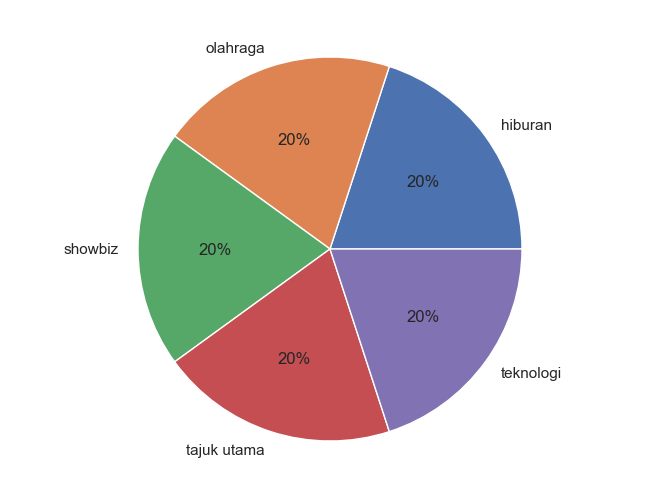

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = news['kategori'].sort_values().unique().tolist()
mood_val_count = news.kategori.value_counts()
ax.pie(mood_val_count, labels=labels, autopct='%.0f%%')
plt.show()

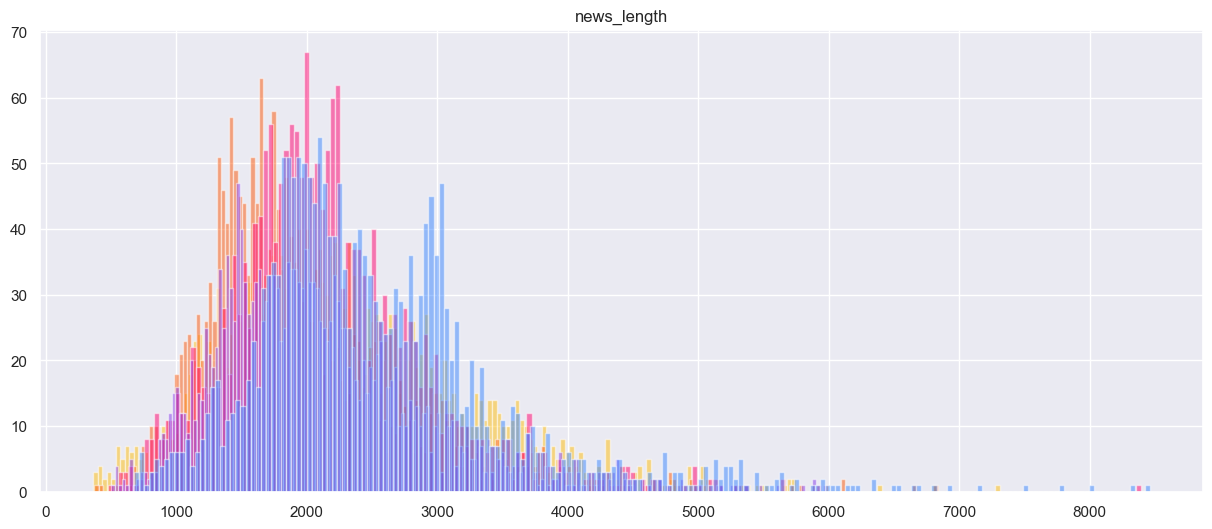

In [17]:
feature = ['news_length']
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
news[news.kategori == 'hiburan'][feature].hist(bins=200, color='#FFBE0B', alpha=0.5, ax=ax)
news[news.kategori == 'olahraga'][feature].hist(bins=200, color='#FB5607', alpha=0.5, ax=ax)
news[news.kategori == 'showbiz'][feature].hist(bins=200, color='#FF006E', alpha=0.5, ax=ax)
news[news.kategori == 'tajuk utama'][feature].hist(bins=200, color='#8338EC', alpha=0.5, ax=ax)
news[news.kategori == 'teknologi'][feature].hist(bins=200, color='#3A86FF', alpha=0.5, ax=ax)
plt.show()

## Feature Engineering

Tahapan feature engineering:
1. Lower Casing
2. Remove Number
3. Remove Punctuation

### Lower Casing

In [18]:
news['artikel_lower'] = news['artikel'].apply(lambda text: text.lower())
news[['artikel','artikel_lower']].head()

,artikel,artikel_lower
0,Uber pada hari Jumat mengatakan akan menguak d...,uber pada hari jumat mengatakan akan menguak d...
1,"Menyusul jejak NES Classic Edition , SNES Clas...","menyusul jejak nes classic edition , snes clas..."
2,"MDI Ventures , perusahaan modal ventura yang d...","mdi ventures , perusahaan modal ventura yang d..."
3,Mazda masih menutup rapat informasi soal sport...,mazda masih menutup rapat informasi soal sport...
4,"Sampai di akhir tahun 2017 ini , frasa “ print...","sampai di akhir tahun 2017 ini , frasa “ print..."


### Remove Punctuation

In [23]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text.translate(str.maketrans('','', PUNCT_TO_REMOVE))

news['artikel_rm_punct'] = news['artikel_lower'].apply(remove_punctuation)
news[['artikel_lower','artikel_rm_punct']].head()

,artikel_lower,artikel_rm_punct
0,uber pada hari jumat mengatakan akan menguak d...,uber pada hari jumat mengatakan akan menguak d...
1,"menyusul jejak nes classic edition , snes clas...",menyusul jejak nes classic edition snes class...
2,"mdi ventures , perusahaan modal ventura yang d...",mdi ventures perusahaan modal ventura yang di...
3,mazda masih menutup rapat informasi soal sport...,mazda masih menutup rapat informasi soal sport...
4,"sampai di akhir tahun 2017 ini , frasa “ print...",sampai di akhir tahun ini frasa “ printer ya...


## Text Preprocessing

Tahapan preprocessing teks:
- Tokenization
- Stopword Removal
- Stemming
- Lemmatization

In [ ]:
nltk.download('stopwords')
", ".join(stopwords.words('english'))

### Tokenizer

In [24]:
def tokenizer(text):
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokenizer = tokenizer.tokenize(text)
    return tokenizer

news['artikel_tokenizer'] = news['artikel_rm_punct'].apply(tokenizer)
news[['artikel_rm_punct','artikel_tokenizer']].head()

,artikel_rm_punct,artikel_tokenizer
0,uber pada hari jumat mengatakan akan menguak d...,"[uber, pada, hari, jumat, mengatakan, akan, me..."
1,menyusul jejak nes classic edition snes class...,"[menyusul, jejak, nes, classic, edition, snes,..."
2,mdi ventures perusahaan modal ventura yang di...,"[mdi, ventures, perusahaan, modal, ventura, ya..."
3,mazda masih menutup rapat informasi soal sport...,"[mazda, masih, menutup, rapat, informasi, soal..."
4,sampai di akhir tahun ini frasa “ printer ya...,"[sampai, di, akhir, tahun, ini, frasa, printer..."


### Stopword Removal

In [26]:
def stopwords_removal(text):
    list_stopwords = set(stopwords.words('indonesian'))
    stopwords_rmv = [s for s in text if s not in list_stopwords]
    stopwords_rmv = ' '.join(stopwords_rmv)
    return stopwords_rmv

news['artikel_stopword_rmv'] = news['artikel_tokenizer'].apply(stopwords_removal)
news[['artikel_tokenizer','artikel_stopword_rmv']].head()

,artikel_tokenizer,artikel_stopword_rmv
0,"[uber, pada, hari, jumat, mengatakan, akan, me...",uber jumat menguak data perjalanan paris publi...
1,"[menyusul, jejak, nes, classic, edition, snes,...",menyusul jejak nes classic edition snes classi...
2,"[mdi, ventures, perusahaan, modal, ventura, ya...",mdi ventures perusahaan modal ventura didukung...
3,"[mazda, masih, menutup, rapat, informasi, soal...",mazda menutup rapat informasi sportscar anyar ...
4,"[sampai, di, akhir, tahun, ini, frasa, printer...",frasa printer mencetak video terdengar mustahi...


### Lemmatization

In [13]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iwanXone\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

news['artikel_lemmatize'] = news['artikel_stopword_rmv'].apply(lemmatize_words)
news[['artikel_stopword_rmv','artikel_lemmatize']].head()

,artikel_stopword_rmv,artikel_lemmatize
0,uber jumat menguak data perjalanan paris publi...,uber jumat menguak data perjalanan paris publi...
1,menyusul jejak nes classic edition snes classi...,menyusul jejak ne classic edition snes classic...
2,mdi ventures perusahaan modal ventura didukung...,mdi venture perusahaan modal ventura didukung ...
3,mazda menutup rapat informasi sportscar anyar ...,mazda menutup rapat informasi sportscar anyar ...
4,frasa printer mencetak video terdengar mustahi...,frasa printer mencetak video terdengar mustahi...


### Label Encoder

In [28]:
news['kategori'] = LabelEncoder().fit_transform(news['kategori'])
news[['artikel_stopword_rmv','artikel_lemmatize','kategori']].head()

,artikel_stopword_rmv,artikel_lemmatize,kategori
0,uber jumat menguak data perjalanan paris publi...,uber jumat menguak data perjalanan paris publi...,4
1,menyusul jejak nes classic edition snes classi...,menyusul jejak ne classic edition snes classic...,4
2,mdi ventures perusahaan modal ventura didukung...,mdi venture perusahaan modal ventura didukung ...,4
3,mazda menutup rapat informasi sportscar anyar ...,mazda menutup rapat informasi sportscar anyar ...,4
4,frasa printer mencetak video terdengar mustahi...,frasa printer mencetak video terdengar mustahi...,4


## Splitting Data

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
x_train, x_test, y_train, y_test = train_test_split(news['artikel_lemmatize'],
                                                    news['kategori'], 
                                                    test_size=0.3, 
                                                    random_state=45)

## Feature Extraction

### Term Frequency–Inverse Document Frequency (TF-IDF)

In [31]:
tfidf = TfidfVectorizer()
tfidf.fit(x_train.values)
train_tfidf = tfidf.transform(x_train.values)
test_tfidf = tfidf.transform(x_test.values)

# print(tfidf.get_feature_names())

In [32]:
train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
df_tfidf = pd.DataFrame(train_tfidf.todense().T,
                        index=tfidf.get_feature_names(),
                        columns=[f'D{i+1}' for i in range(len(train_tfidf.toarray()))])
df_tfidf.sample(5)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,...,D6976,D6977,D6978,D6979,D6980,D6981,D6982,D6983,D6984,D6985,D6986,D6987,D6988,D6989,D6990,D6991,D6992,D6993,D6994,D6995,D6996,D6997,D6998,D6999,D7000
ounce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ekatarina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rasialnya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
girlgrup,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
exline,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

### Random Fores Classifier

In [36]:
random_fores = RandomForestClassifier()
random_fores.fit(train_tfidf, y_train)

RandomForestClassifier()

In [37]:
random_fores.score(train_tfidf, y_train), random_fores.score(test_tfidf, y_test)

(1.0, 0.9033333333333333)

In [38]:
pred = random_fores.predict(test_tfidf)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82       566
           1       0.96      0.97      0.97       593
           2       0.88      0.93      0.90       627
           3       0.83      0.94      0.88       600
           4       0.98      0.91      0.94       614

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.91      0.90      0.90      3000



### Multinomial Naive Bayes

In [39]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(train_tfidf, y_train)

MultinomialNB()

In [40]:
multinomial_nb.score(train_tfidf, y_train), multinomial_nb.score(test_tfidf, y_test)

(0.9408571428571428, 0.911)

In [41]:
pred = multinomial_nb.predict(test_tfidf)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82       566
           1       0.98      0.97      0.98       593
           2       0.88      0.94      0.91       627
           3       0.87      0.91      0.89       600
           4       0.94      0.96      0.95       614

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



### XGB Classifier

In [42]:
xgb = XGBClassifier()
xgb.fit(train_tfidf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [43]:
xgb.score(train_tfidf, y_train), xgb.score(test_tfidf, y_test)

(1.0, 0.9043333333333333)

In [44]:
pred = xgb.predict(test_tfidf)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       566
           1       0.97      0.97      0.97       593
           2       0.88      0.90      0.89       627
           3       0.85      0.92      0.88       600
           4       0.97      0.94      0.96       614

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.91      0.90      0.90      3000

